# Project wAIge

Project wAIge is an AI application that determines a person's salary, depending on multiple variables, to be either one of the following:

- Below 19,000 pesos a month
- Between 19,000 and 110,000 a month
- Greater than 110,000 a month

## Dataset

The dataset that will be used is taken from the Family Income and Expenditure Survey (2017)

The columns that will be used from the dataset, which will server as the variables for prediction, are the following:

Feature variables:
- Household Head Sex
- Household Head Age
- Household Head Marital Status
- Household Head Highest Grade Completed
- Household Head Occupation
- Household Head Class of Worker

Target variable:
- Total Household Income

## Decision Tree

### Libraries

This section contains the libraries that will be used for this project

In [58]:
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, clear_output
from anytree import Node, RenderTree
from anytree.exporter import DotExporter
from pathlib import Path

### Data Preprocessing

Before proceeding any further, this section alters the dataset to contain only the necessary information that will be used

In [59]:
# The variable df will contain the altered dataset
df = pd.read_csv("../data/project_data.csv")

# ---------------------------------------------------------------------------------------------
# These lines of comments were used to shuffle the rows of the dataset for more randomness
# They were used once and commented out so as to not have an inconsistent model
# df = df.sample(frac=1).reset_index(drop=True)
# df.to_csv("../data/project_data.csv", index=False)
# ---------------------------------------------------------------------------------------------

# This section removes the unnecessary columns
df = df[["Main Source of Income", "Household Head Sex", "Household Head Age", "Household Head Marital Status", "Household Head Highest Grade Completed", "Household Head Occupation", "Household Head Class of Worker", "Total Household Income"]]

# This section removes rows that ...
# ...contain "NA" under "Household Head Occupation", ...
df = df[df["Household Head Occupation"].notnull()]
# ...are not "Wage/Salaries" under "Main Source of Income" (also drop "Main Source of Income" afterwards), ...
df = df[df["Main Source of Income"] == "Wage/Salaries"]
df.pop("Main Source of Income")
# ...are "Workers reporting occupations unidentifiable or inadequately defined" under "Household Head Occupation", ...
df = df[df["Household Head Occupation"] != "Workers reporting occupations unidentifiable or inadequately defined"]
# ... and are "Unknown" under "Household Head Marital Status"
df = df[df["Household Head Marital Status"] != "Unknown"]

# This section converts the total yearly income to monthly income...
df["Total Household Income"] = df["Total Household Income"].div(12).round(0)
df["Total Household Income"] = [int(x) for x in df["Total Household Income"]]
# ... and mask it based on our target predictions:
#       1 = monthly salary < 19000
#       2 = 19000 <= monthly salary <= 110000
#       3 = monthly salary > 110000
df["Total Household Income"].mask(df["Total Household Income"] < 19000, 1, inplace=True)
df["Total Household Income"].mask(df["Total Household Income"] > 110000, 3, inplace=True)
df["Total Household Income"].mask(df["Total Household Income"] >= 19000 , 2, inplace=True)

# This section renames the remaining columns
df.columns = ["sex", "age", "marital_status", "educational_attainment", "occupation", "work_class", "monthly_salary"]

# Mask age
# print(df["age"].unique()) # Uncomment this line to see the original values
df["age"].mask(df["age"] <= 25, 1, inplace=True)
df["age"].mask(df["age"] > 65, 3, inplace=True)
df["age"].mask(df["age"] > 25, 2, inplace=True)


# Mask "marital_status" by reclassifying some values to "Single"
# print(df["marital_status"].unique()) # Uncomment this line to see the original values
df["marital_status"].mask(df["marital_status"] == "Widowed" , "Single", inplace=True)
df["marital_status"].mask(df["marital_status"] == "Divorced/Separated" , "Single", inplace=True)
df["marital_status"].mask(df["marital_status"] == "Annulled" , "Single", inplace=True)

# Mask "educational_attainment" by classifying the values to the following:
#       0 = Grade School and below
#       1 = Some High School
#       2 = High School Graduate
#       3 = Some College
#       4 = Bachelor's Degree
#       5 = Graduate Degree
# print(df["educational_attainment"].unique()) # Uncomment this line to see the original values
df["educational_attainment"].mask(df["educational_attainment"] == "No Grade Completed" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Preschool" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Grade 1" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Grade 2" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Grade 3" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Grade 4" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Grade 5" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Grade 6" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Elementary Graduate" , 0, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "First Year High School" , 1, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Second Year High School" , 1, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Third Year High School" , 1, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "High School Graduate" , 2, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "First Year Post Secondary" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "First Year College" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Second Year Post Secondary" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Second Year College" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Third Year College" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Fourth Year College" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Other Programs in Education at the Third Level, First Stage, of the Type that Leads to an Award not Equivalent to a First University or Baccalaureate Degree" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Other Programs of Education at the Third Level, First Stage, of the Type that Leads to a Baccalaureate or First University/Professional Degree (HIgher Education Level, First Stage, or Collegiate Education Level)" , 3, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Teacher Training and Education Sciences Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Transport Services Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Business and Administration Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Social and Behavioral Science Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Agriculture, Forestry, and Fishery Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Engineering and Engineering Trades Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Engineering and Engineering trades Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Basic Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Health Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Security Services Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Humanities Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Computing/Information Technology Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Mathematics and Statistics Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Personal Services Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Journalism and Information Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Architecture and Building Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Life Sciences Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Law Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Manufacturing and Processing Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Physical Sciences Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Environmental Protection Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Social Services Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Veterinary Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Arts Programs" , 4, inplace=True)
df["educational_attainment"].mask(df["educational_attainment"] == "Post Baccalaureate" , 5, inplace=True)

# Mask "occupation" by classifying the values to the following:
#       1 = Agriculture, Forestry, and Fishing
#       2 = Mining and Quarrying
#       3 = Manufacturing
#       4 = Electricity, Gas, Steam, and Air Conditioning Supply
#       5 = Water Supply; Sewerage, Waste Management and Remediation Activities
#       6 = Construction
#       7 = Wholesale and Retail Trade; Repair of Motor Vehicles and Motorcycles
#       8 = Transportation and Storage
#       9 = Accommodation and Food Service Activities
#       10 = Information and Communications
#       11 = Financial and Insurance Activities
#       12 = Real Estate Activities
#       13 = Professional, Scientific, and Technical Activities
#       14 = Administrative and Support Service Activities
#       15 = Education Except Public Education
#       16 = Human Health and Social Work Activities
#       17 = Arts, Entertainment, and Recreation
#       18 = Repair of Computers and Personal and Household Goodsl Other Personal Service Activities
# print(df["occupation"].unique()) # Uncomment this line to see the original values
df["occupation"].mask(df["occupation"] == "General elementary education teaching professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Transport conductors" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Farmhands and laborers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Rice farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors in transportation, storage and communications" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Heavy truck and lorry drivers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Stocks clerks" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Justices" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Other social science professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Protective services workers n. e. c." , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Secretaries" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Foresters and related scientists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Shop salespersons and demonstrators" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "College, university and higher education teaching professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Car, taxi and van drivers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Motor vehicle mechanics and related trades workers" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Motorcycle drivers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Statistical, mathematical and related associate professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Lineman, line installers and cable splicers" , 4, inplace=True)
df["occupation"].mask(df["occupation"] == "Carpenters and joiners" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Building construction laborers" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Inland and coastal waters fishermen" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Painters and related workers" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Traditional chiefs and heads of villages" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Construction and maintenance laborers: roads, dams and similar constructions" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Helpers and cleaners in offices, hotels and other establishments" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors n. e. c." , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Messengers, package and luggage porters and deliverers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Social work associate professionals" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Hand packers and other manufacturing laborers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Sweepers and related laborers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Medical technologists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Cooks" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "School supervisors and principals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Wood and related products assemblers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Police inspectors and detectives" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Coconut farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors in wholesale and retail trade" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Forestry laborers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "School principals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Civil engineers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Prison guards" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Hog raising farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Assembling laborers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Hand launderers and pressers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Tellers and other counter clerks" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Government administrators (including career executive service officers)" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Plumbers, pipe fitters and other related workers" , 5, inplace=True)
df["occupation"].mask(df["occupation"] == "Masons and related concrete finishers" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Mechanical engineering technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Production supervisors and general foremen" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Welders and flamecutters" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Food preservers" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Basketry weavers, brush makers and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors in manufacturing" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Statistical and finance clerks" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Wood products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Building and related electricians" , 4, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in restaurant and hotels" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Other supervisors, n. e. c." , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Doorkeepers, watchpersons and related workers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Vegetable farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Waiters, waitresses and bartenders" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Ships' deck officers and pilots" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Other office clerks" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Child care workers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Mining and quarrying laborers" , 2, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors of business services" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Religious professionals" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Earth-moving and related plant operators" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Motorized farm and forestry plant operators" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Tailors, dressmakers and hatters" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Fruit tree farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Corn farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Broadcasting and telecommunications equipment operators" , 10, inplace=True)
df["occupation"].mask(df["occupation"] == "General secondary education teaching professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Accounting and bookkeeping clerks" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Fishery laborers and helpers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Street ambulant vendors" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Police officers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Cabinet/furniture makers and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Domestic helpers and cleaners" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Blacksmiths, hammersmiths, and forging-press workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Butchers, fishmongers and related food preparers" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Bet bookmakers and croupiers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Transport clerks" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Enlisted personnel n. e. c." , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Directors and chief executives of corporations" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Combat soldiers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Building caretakers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Concessionaires and loggers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Institution-based personal care workers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Debt collectors and related workers" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Vocational education teaching professionals" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Wood processing plant operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Shotfirers and blasters" , 2, inplace=True)
df["occupation"].mask(df["occupation"] == "Fruit, vegetable and nut processing machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Lifting truck operators" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Bakers, pastry cooks and confectionery makers" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Photographic products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Rattan, bamboo and other wicker furniture makers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Root crops farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Chicken farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Non-ordained religious associate professionals" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Mining-plant operators" , 2, inplace=True)
df["occupation"].mask(df["occupation"] == "Legislative officials" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Pawnbrokers and money lenders" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Sheet-metal workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Forest tree planters" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Stall and market salespersons" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors in agriculture, hunting, forestry and fishing" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Market and sidewalk stall vendors" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Personnel and industrial relations managers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Cement and other mineral products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Firefighters" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors of restaurants and hotels" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Weavers, knitters and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Silk-screen, block and textile printers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Garbage collectors" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Traditional medicine practitioners" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Cashiers and ticket clerks" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Freight handlers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Varnishers and related painters" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Accountants and auditors" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Hairdressers, barbers, beauticians and related workers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Library and filing clerks" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Door-to-door and telephone salespersons" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Undertakers and embalmers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Minor forest products gatherers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Cattle and dairy farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in transport, storage and communications" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Grain and spice milling machine operators" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Deep-sea fishermen" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Mechanical engineers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Agronomists and related scientists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Research and development managers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Other machine operators and assemblers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Sewers, Embroiderers and related workers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Safety, health and quality inspectors (vehicles, processes and products)" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Electronic equipment assemblers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Textile, leather and related patternmakers and cutters" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Roofers" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Other field crop farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Sugarcane farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Power production plant operators" , 4, inplace=True)
df["occupation"].mask(df["occupation"] == "Metal-wheel grinders, polishers and tool sharpeners" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Other computer professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Electrical mechanics and fitters" , 4, inplace=True)
df["occupation"].mask(df["occupation"] == "Structural-metal preparers, erectors and related workers" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Sales and marketing managers" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Professional nurses" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Professional, technical and related officers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Other livestock farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Ship's deck crews and related workers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Athletes and related workers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Decorators and commercial designers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Automated assembly-line operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Labor contractors and employment agents" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Sugar production machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Veterinary assistants" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Charcoal makers and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Glass makers, cutters, grinders and finishers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in personal care, cleaning and relative services" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Tool-makers and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Transport and communications service supervisors n. e. c." , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Other specialized managers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Riggers and cable splicers" , 4, inplace=True)
df["occupation"].mask(df["occupation"] == "Staff officers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Miners and quarry workers" , 2, inplace=True)
df["occupation"].mask(df["occupation"] == "Technical and commercial sales representatives" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Computer programmers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Receptionists and information clerks" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Pharmacists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Housekeepers and related workers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Other administrative associate professionals" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Appraisers and valuers" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Government tax and excise officials" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Administrative secretaries and related associate professionals" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Bus drivers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Teaching associate professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Finance and administration managers" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Commanding officers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Nutritionists-dietitians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Professional midwives" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Bookkeepers" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Field legumes farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Street, nightclub and related musicians, singers and dancers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Electrical Engineers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Mining and metallurgical engineering technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Draftsmen" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Computer engineers and related professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Ornamental plant growers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Other life science technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Dairy products makers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Legal and related business associate professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Mail carriers and sorting clerks" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Well drillers and borers and related workers" , 5, inplace=True)
df["occupation"].mask(df["occupation"] == "Other business professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Farm technicians" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Economists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors in personal care, cleaning and relative services" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Building frame and related trades workers n. e. c." , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Chemists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Insurance representatives" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Coffee and cacao farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Cotton and fiber crops farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Civil engineering technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Word processor and related operators" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Production clerks" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Meat and fish processing machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Other personal services workers, n. e. c." , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Crane, hoist and related plant operators" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Composers, musicians and singers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Photographers and image and sound recording equipment operators" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Hand or pedal vehicle drivers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Statisticians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Customs and immigration inspectors" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Electronics and communications engineers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Fashion and other models" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Metal melters, caster and rolling mill operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Weaving and knitting machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Personnel and human resource development professionals" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Mechanical machinery assemblers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Rubber products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Sales supervisors in retail trade" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Metal drawers and extruders" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Floor layers and tile setters" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Systems analysts and designers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Government licensing officials" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Librarians, archivists and curators" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Incinerator, water treatment and related plant operators" , 5, inplace=True)
df["occupation"].mask(df["occupation"] == "Town planners and related professionals" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Home-based personal care workers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Education methods specialists" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Sculptors, painters and related artists" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "General managers/managing proprietors in construction" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Buyers" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Duck raisers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Architects" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Medical doctors" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Other health associate professionals (except nursing)" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Estate agents" , 12, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in wholesale and retail trade" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Air transport service supervisors" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Companions and valets" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in manufacturing" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Electrical equipment assemblers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Computer equipment operators" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Metal, rubber and plastic products assemblers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Electronics and communications engineering technicians" , 10, inplace=True)
df["occupation"].mask(df["occupation"] == "Industrial engineers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Baked goods and cereal and chocolate products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Metal molders and coremakers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Marine craft mechanics" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Bookbinders and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Travel consultants and organizers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Jewelry and precious metal workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Travel guides" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Faith healers" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Shoe cleaning and other street services elementary occupations" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Social work professionals" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Data entry operators" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Musical instrument makers and tuners" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Machine-tool setters and setter operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Stenographers and typists" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Compositors, typesetters and related workers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Stone splitters, cutters and carvers" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Ship and aircraft controllers and technicians" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Photographic and related workers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Other orchard farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Lawyers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Electronics mechanics and servicers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Aircraft engine mechanics and fitters" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in business services" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Precision instrument makers and repairers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Medical assistants" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Air traffic safety technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Other plant growers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Pressman letterpresses and related workers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Other health professionals (except nursing)" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Mineral ore and stone-processing plant operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in agriculture, hunting, forestry and fishery" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Shoemakers and related workers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Agricultural or industrial machinery mechanics and fitters" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Pre-elementary education teaching professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Nonformal education teaching professionals other than technical and vocational trainors/instructors" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Fish-farm cultivators (excluding prawns)" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Radio, television and other announcers" , 10, inplace=True)
df["occupation"].mask(df["occupation"] == "Sales supervisors in wholesale trade" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Insulation workers" , 4, inplace=True)
df["occupation"].mask(df["occupation"] == "Machine tool operators" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Authors, journalists and other writers" , 10, inplace=True)
df["occupation"].mask(df["occupation"] == "Technician, skilled, semi-skilled workers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Tobacco preparers and tobacco products makers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Other physical science and engineering technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Dentists" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Other sales supervisors" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Brewers and wine and other beverage machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Supply and distribution managers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Papermaking plant operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Pharmaceutical and toiletry products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Handicraft workers in wood and related materials" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Paperboard, textile and related products assemblers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Building and fire inspectors" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Telecommunication equipment installers and repairers" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Plastic products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Dairy products machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Midwifery associate professionals" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Science and mathematics teaching professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Postal service supervisors" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Science and mathematics elementary education teaching professionals" , 15, inplace=True)
df["occupation"].mask(df["occupation"] == "Hunting and trapping laborers" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Other government associate professionals" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Coding, proof-reading and related clerks" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Dental assistants" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Geodetic engineers and related professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Business machines mechanics and repairers" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Bleaching, dyeing and cleaning machine operators" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Other finance and sales associate professionals" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Computer assistants" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Life science technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Metal finishing, plating and coating machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Trade brokers" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Other animal raisers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Pharmaceutical assistants" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Other poultry farmers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Builders (traditional materials)" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Maritime transport service supervisors" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Service and related workers" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Medical equipment operators" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Electronics fitters" , 18, inplace=True)
df["occupation"].mask(df["occupation"] == "Fiber preparing, spinning and winding machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Woodworking machine setters and setter-operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Food and beverage tasters and graders" , 9, inplace=True)
df["occupation"].mask(df["occupation"] == "Hunters and trappers" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Production and operations managers in construction" , 6, inplace=True)
df["occupation"].mask(df["occupation"] == "Other business services and trade brokers" , 11, inplace=True)
df["occupation"].mask(df["occupation"] == "Shoemaking and related machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Other aqua products cultivators" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Government social benefits officials" , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Potters and related clay and abrasive formers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Other creative or performing artists" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Fiber preparers" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Drivers of animal-drawn vehicles and machinery" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Officers, n. e. c." , 16, inplace=True)
df["occupation"].mask(df["occupation"] == "Seaweeds cultivators" , 1, inplace=True)
df["occupation"].mask(df["occupation"] == "Vehicle, window and related cleaners" , 14, inplace=True)
df["occupation"].mask(df["occupation"] == "Other engineers and related professionals" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Chemical engineers" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Tanners" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Choreographers and dancers" , 17, inplace=True)
df["occupation"].mask(df["occupation"] == "Glass and ceramics kiln and related machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Textile and leather products machine operators n. e. c." , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Locomotive engine drivers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Chemical products machine operators n. e. c." , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Wood treaters" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Electrical engineering technicians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Advertising and public relations managers" , 7, inplace=True)
df["occupation"].mask(df["occupation"] == "Paper pulp plant operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Veterinarians" , 13, inplace=True)
df["occupation"].mask(df["occupation"] == "Sewing machine operators" , 3, inplace=True)
df["occupation"].mask(df["occupation"] == "Aircraft pilots, navigators and flight engineers" , 8, inplace=True)
df["occupation"].mask(df["occupation"] == "Glass, ceramics and related plant operators n. e. c." , 3, inplace=True)

# Mask "work_class" by reclassifying the values into either "Public" or "Private"
# print(df["work_class"].unique()) # Uncomment this line to see the original values
df["work_class"].mask(df["work_class"] == "Worked for government/government corporation" , "Public", inplace=True)
df["work_class"].mask(df["work_class"] == "Worked for private establishment" , "Private", inplace=True)
df["work_class"].mask(df["work_class"] == "Employer in own family-operated farm or business" , "Private", inplace=True)
df["work_class"].mask(df["work_class"] == "Self-employed wihout any employee" , "Private", inplace=True)
df["work_class"].mask(df["work_class"] == "Worked without pay in own family-operated farm or business" , "Private", inplace=True)
df["work_class"].mask(df["work_class"] == "Worked for private household" , "Private", inplace=True)
df["work_class"].mask(df["work_class"] == "Worked with pay in own family-operated farm or business" , "Private", inplace=True)

# print(len(df))

### Splitting the dataset

In this section we'll split the preprocessed dataset to a training set and a testing set in an 80:20 ratio. We will also create a dictionary containing the samples, feature variables, and target variable for the training set to be used in the decision tree later on.

In [60]:
# The preprocessed dataset has 17738 rows.
# That would roughly translate to 14190 rows for the training set and 3548 rows for the testing set.

columns = list(df.columns)
features = columns[:-1]
target = columns[-1]

# Training set
df_training = df.iloc[:14190]
# print(len(df_training))

training_set = {
    "samples"  :  df_training,
    "features" :  features,
    "target"   :  target
}

# Testing set
df_testing = df.iloc[14190:]
# print(len(df_testing))

testing_set = df_testing[features]
expected_result = df_testing[target]

### Modeling the Decision Tree

#### Decision Tree Class

This part is borrowed from one of the machine exercises, implementing the object class for the decision tree.

In [61]:
class DecisionTree:

  def __init__(self, dataset, **kwargs):
    self.samples  = dataset['samples']
    self.target   = dataset['target']
    self.features = dataset['features']

    self.classes  = self.samples[self.target].unique()
    self.values   = {feature: self.samples[feature].unique() for feature in self.features}

    self.node_ctr = 0 # for plotting decision tree nodes
    self.hypothesis = Node(0)


  #Functions in these marked sections are personal implementations taken from our answers for the machine exercise
  #----------------------------------------------------------------------------------------------- 
  # START SECTION
  #----------------------------------------------------------------------------------------------- 

  def plurality_value(self, samples):
    # Randomly shuffle samples to break majority ties
    samples = samples.sample(frac=1, random_state=180)
    samples_target = samples[self.target] 
    major_class = None
    if list(samples_target).count('Yes') > list(samples_target).count('No'):
      major_class = 'Yes'
    elif list(samples_target).count('Yes') < list(samples_target).count('No'):
      major_class = 'No'
    else:
      # if tie: return samples_target.iloc[0]
      major_class = samples_target.iloc[0]
    return major_class

  def H(self, samples):
    target = self.target
    classes = self.classes
    entropy = -1
    
    # Computes the probabilities for each class
    sample_probabilities = {c: len(samples[samples[target] == c])/len(samples) for c in classes 
                            if len(samples[samples[target] == c])>0 and len(samples) > 0}

    var = 0
    for i in sample_probabilities:
      prob = np.array([sample_probabilities[i]])
      var += sample_probabilities[i] * (np.log2(prob)[0])
    entropy = var if var == 0 else -var
    return entropy

  def importance(self, feature, samples):
    values = self.values
    H = self.H
    gain = -1

    n = len(samples)
    if n < 1: return 0

    # Choose samples with Feature = f   
    def choose(f):
      return samples[samples[feature]==f]

    # Compute remainder
    remainder = 0
    for i in values[feature]:
      subset = choose(i)
      remainder += (len(subset) / len(samples)) * H(subset)
    # Compute gain
    gain = H(samples) - remainder
    return gain

  #----------------------------------------------------------------------------------------------- 
  # END SECTION
  #----------------------------------------------------------------------------------------------- 

  def decision_tree_learning(self, samples, features, parent):
    """ 
    Algorithm for decision tree learning (AIMA Fig 18.5)

    Parameters
    - samples: remaining samples
    - features: remaining features
    - parent: tuple containing parent samples (for empty samples case),
              parent node (for tree), and parent label (for visualization)

    Returns
    - tree: current tree / subtree
    """
    self.node_ctr+=1
    target = self.target
    values = self.values
    
    # No more samples left -> get majority of parent samples
    if len(samples)==0:   
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target,
                                                self.plurality_value(parent['samples'])), 
                                                parent=parent['node'])

    # Final classification (leaf)
    elif (samples[target] == samples[target].iloc[0]).all():
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target, 
                                               self.plurality_value(samples)), 
                                               parent=parent['node'])

    # No more features left, but there are still samples -> get majority of samples
    elif len(features)==0:
      return Node("[{0}] {1} | {2}={3}".format(self.node_ctr, parent['label'], target, 
                                               self.plurality_value(samples)), 
                                               parent=parent['node'])

    # choose next feature branch  
    else:
      feature_importance = {feature: self.importance(feature, samples) for feature in features}
      best_feature = max(feature_importance, key=feature_importance.get)
      #bprint(feature_importance)
      if(parent['label']):
        tree = Node("[{0}] {1} | {2}".format(self.node_ctr, parent['label'], best_feature), 
                                             parent=parent['node'])

      else:
        self.node_ctr = 1
        tree = Node("[{0}] {1}".format(self.node_ctr, best_feature), parent=parent['node'])

      for value in sorted(values[best_feature]):        
        subfeatures = [x for x in features if x != best_feature]
        subsamples = samples[samples[best_feature]==value]
        subsamples = subsamples[subfeatures+[target]]
        subtree = self.decision_tree_learning(subsamples, subfeatures, 
                                             {'samples': samples, 'node': tree, 
                                             'label': "{0}={1}".format(best_feature, value)})
      return tree

  def fit(self):
    """
    Train the model with the given samples and features
    """  
    self.hypothesis = self.decision_tree_learning(self.samples, self.features, 
                                            parent={'samples': self.samples, 
                                                    'node': None, 'label': None})  
    
  #----------------------------------------------------------------------------------------------- 
  # START SECTION
  #----------------------------------------------------------------------------------------------- 

  def predict(self, sample):
    tree = self.hypothesis

    node = tree.name  
    feature = re.search(r"\[(\w+)\]\s*(\w+)", node).group(2)
    prediction = None

    while(True):
      for i in tree.children:
        if str(sample[feature]) != i.name.split()[1].split('=')[1]:
          continue
        parsed = i.name.split()[-1].split('=')
        if parsed[0] == self.target:
          prediction = parsed[1]
          return prediction
        tree = i
        feature = parsed[0]
        break

  #----------------------------------------------------------------------------------------------- 
  # END SECTION
  #----------------------------------------------------------------------------------------------- 

### Training the Model

We just have to convert our training set to a decision tree and call the function fit.

In [62]:
dtree_model = DecisionTree(training_set)
dtree_model.fit()

#### Visualization

With the decision tree for the training set created, the next block of code allows us to visualize it. This is also taken from the machine exercise.

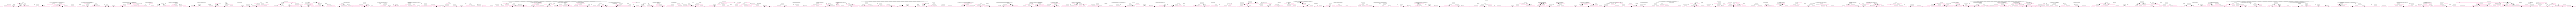

In [63]:
def set_terminal(node):
    attrs = [f'shape=box']
    attrs += [f'color=hotpink'] if not node.children else [f'color=dimgray']
    # attrs += [f'color={node.color}'] if hasattr(node, 'color') else []
    # attrs += [f'shape={node.shape}'] if hasattr(node, 'shape') else [f'shape=box']
    return ', '.join(attrs)

# Print the decision tree
# print(RenderTree(dtree_model.hypothesis), "\n")

# Uncomment this block of code to display the image. It is to note, however, that the image 
# essentially has no use since the decision tree is much, much more wider than its height,
# making it unreadable.  
# See /results/training_set.png to see (or actually, not see) the decision tree.
#-------------------------------------------------------------------------------------------
# img_file = Path('../results/training_set.png')
# img_title = "Decision Tree for Project wAIge Training Set"
# decision_tree = DotExporter(dtree_model.hypothesis, nodeattrfunc=set_terminal, 
#                             options=['labelloc="t";','label="{0}";'.format(img_title),
#                                      'fontsize="20";', 
#                                      'graph [fontname = "helvetica"];',
#                                      'node [fontname = "helvetica"];']
#                            ).to_picture(img_file)

# from IPython.display import Image
# Image(img_file)
#-------------------------------------------------------------------------------------------

### Predictions

Now, we will use the testing set to see how well our model works.

Accuracy:  68.94%


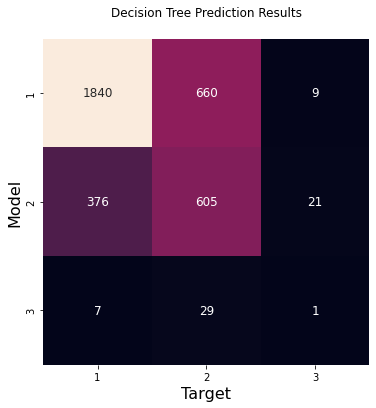

In [64]:
total_samples = len(testing_set)
predictions = []

# This section predicts the value of the target variable of the testing set.
for i in range(total_samples):
    predictions.append(int(dtree_model.predict(testing_set.iloc[i])))

# This section computes for the accuracy of the predictions by matching it against the actual value of the target variable of the testing set.
err = 0
for i in range(total_samples):
    if predictions[i] != int(expected_result.iloc[i]):
        err += 1
print("Accuracy: ", round((1 - (err/total_samples)) * 100, 2), end='')  # Percentage of accuracy
print("%")

# This section displays the heat map of the results. This was taken from the machine exercise as well.
classes = [1, 2, 3]
y_ = np.array(predictions)
x_ = np.array(list(expected_result))
y = pd.Categorical(y_, categories=classes)
x = pd.Categorical(x_, categories=classes)
results = pd.crosstab(y, x, dropna=False)
fig, ax = plt.subplots(figsize=(16, 6))
p = sns.heatmap(results, annot=True, ax=ax, cbar=False, 
                annot_kws={"fontsize":12}, fmt='g')
ax.set_aspect('equal')
ax.set_title("Decision Tree Prediction Results", y=1.05)
p.set_xlabel("Target", fontsize=16)
p.set_ylabel("Model", fontsize=16)
plt.show()